<a href="https://colab.research.google.com/github/AscendingGrass/C242-ET01/blob/main/C242_ET01_Benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install unsloth "xformers==0.0.28.post2"
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

In [ ]:
max_seq_length = 8192 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

In [ ]:
import pandas as pd

test_data_path = "./test.csv"
dataset_test = pd.read_csv(test_data_path)

In [ ]:
from unsloth import FastLanguageModel
import torch

models_to_test = [
    "unsloth/Llama-3.2-3B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "AscendingGrass/Llama-3.2_3B_C242-ET01",
    "AscendingGrass/Llama-3.1_8B_C242-ET01",
    "GoToCompany/llama3-8b-cpt-sahabatai-v1-instruct"
]

EOS_TOKEN = "<|eot_id|>"

model_index = 4

model_name = models_to_test[model_index]

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

FastLanguageModel.for_inference(model)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2024.12.4: Fast Llama patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post2. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/143 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

GoToCompany/llama3-8b-cpt-sahabatai-v1-instruct does not have a padding token! Will use pad_token = <|reserved_special_token_250|>.


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096, padding_idx=128255)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSN

In [ ]:
llama3_prompt = """<|begin_of_text|><|start_header_id|>system<|end_header_id|>

{}<|eot_id|><|start_header_id|>user<|end_header_id|>

{}<|eot_id|><|start_header_id|>assistant<|end_header_id|>

{}"""

system_prompt="""Gunakan bahasa indonesia. Anda adalah pembuat soal yang dapat membuat soal yang relevan berdasarkan materi yang ada. Anda harus mengakses informasi dari dokumen yang sesuai dan menghasilkan soal berkualitas tinggi, termasuk soal HOTS. Jika tidak diminta membuat soal maka hiraukan saja teks setelah ini.
\"\"\"Berikut adalah instruksi untuk menghasilkan soal:

1. **Akses Materi**:
   - Akses informasi dari telah tersedia pada pesan chat yang berkaitan dengan modul yang diminta. Pastikan Anda mengambil data yang relevan tentang topik ini. Jika ditanya perihal konteks anda dapat mengambil data dari vector store tool.

1. **Buat Soal Pilihan Ganda (Multiple Choice)**:
   - Berdasarkan data yang diambil, buat soal pilihan ganda dengan 4-5 pilihan jawaban yang relevan.
   - Pastikan soal tidak hanya menguji pengetahuan dasar, melainkan menguji aplikasi, analisis, dan sintesis konsep. Hindari membuat soal berbentuk esai atau pertanyaan terbuka.

2. **Buat Soal Benar/Salah (True or False)**:
   - Gunakan informasi yang diambil untuk membuat soal dengan format benar/salah yang menguji definisi, konsep, atau aplikasi dari materi yang dipelajari.
   - Pastikan pernyataan yang diberikan dapat dinilai jelas apakah benar atau salah, dan berikan penjelasan singkat setelah jawaban untuk memperjelas.

3. **Buat Soal Multi-Box Choice (Multiple Correct Answers)**:
   - Berdasarkan informasi yang ada, buat soal multi-box choice di mana lebih dari satu jawaban yang benar. Pastikan soal tersebut jelas menunjukkan bahwa ada lebih dari satu pilihan yang benar dan siswa diminta untuk memilih lebih dari satu jawaban yang tepat.
   - Tentukan dengan jelas berapa banyak jawaban yang benar dalam soal tersebut. Jawaban benar terdiri dari 1-5 dari jumlah pilihan 4-5.

4. **Fokus pada HOTS (Higher Order Thinking Skills)**:
   - Soal HOTS hanya dapat berupa Multiple Choice, Multi-Box Choice, dan True/False.
   - Gunakan data yang relevan untuk menciptakan soal yang mendorong siswa untuk berpikir kritis, menganalisis, dan memberikan solusi berdasarkan pemahaman mereka terhadap konsep yang diajarkan.
   - Pastikan soal yang dibuat menguji pemahaman aplikatif dan bukan hanya konsep dasar atau teori.

5. **Verifikasi Keakuratan Soal**:
   - Setelah soal dibuat, pastikan setiap jawaban sesuai dengan data yang ada. Pastikan bahwa setiap pilihan jawaban atau pernyataan terkait dengan konsep yang benar dan terperinci dari materi yang relevan. Lalu berikan penjelasan diakhir masing-masing soal.

6. **Variasikan Tingkat Kesulitan**:
   - Sesuaikan soal dengan tingkat kesulitan yang berbeda, mulai dari soal dasar yang menguji pemahaman konsep hingga soal yang mengharuskan siswa untuk menganalisis atau mengaplikasikan pengetahuan mereka dalam konteks yang lebih kompleks.

7. **Jumlah Soal**:
   - Jika tidak ada ketentuan jumlah soal, buatlah 5 soal dengan variasi jenis soal yang beragam (pilihan ganda, multi-box choice, dan benar/salah), memastikan soal yang dihasilkan mencakup pilihan ganda dan benar/salah, serta beberapa soal yang menguji keterampilan berpikir tingkat tinggi (HOTS).

8. **Format menggunakan JSON**
  - Berikut contohnya:
{
  "questions": [
    {
      "id": 1,
      "type": "multiple_choice",
      "question": "Apa ibu kota Indonesia?",
      "options": [
        { "id": "a", "text": "Jakarta" },
        { "id": "b", "text": "Surabaya" },
        { "id": "c", "text": "Bandung" },
        { "id": "d", "text": "Yogyakarta" }
      ],
      "correct_answer": "a",
      "explanation": "Ibu kota Indonesia adalah Jakarta, yang merupakan pusat pemerintahan dan ekonomi negara."
    },
    {
      "id": 2,
      "type": "multibox",
      "question": "Pilihlah warna primer!",
      "options": [
        { "id": "a", "text": "Merah" },
        { "id": "b", "text": "Hijau" },
        { "id": "c", "text": "Biru" },
        { "id": "d", "text": "Kuning" }
      ],
      "correct_answer": ["a", "c", "d"],
      "explanation": "Warna primer adalah warna yang tidak bisa dihasilkan dari pencampuran warna lain. Warna primer adalah merah, biru, dan kuning."
    },
    {
      "id": 3,
      "type": "true_false",
      "question": "Sungai Amazon terletak di Afrika.",
      "correct_answer": false,
      "explanation": "Sungai Amazon terletak di Amerika Selatan, bukan di Afrika."
    }
  ]
}

**Catatan**: Dilarang untuk membuat soal dalam bentuk esai, pertanyaan terbuka, atau format lain selain Multiple Choice, Multi-Box Choice, dan True/False. Semua soal harus berupa pilihan ganda, dengan atau tanpa lebih dari satu jawaban yang benar, dan harus mencakup soal HOTS.
\"\"\""""

user_prompt="Jawab Pesan Saya ini \"{}\". anda wajib mengakses data dari vector store tool. Hiraukan data berikut ini jika saya tidak menyuruh anda untuk \"membuat soal\". Data materinya buat soal dari teks ini: \"\"\"{}\"\"\""

question_generation_prompts = dict(
    easy="Buat soal dengan tingkatan Mudah (Tingkat Analisis Kasus Mudah, Tingkat Hafalan Mudah)",
    medium="Buat soal dengan tingkatan Sedang (Tingkat Analisis Kasus Sedang, Tingkat Hafalan Sedang)",
    hard="Buat soal dengan tingkatan Sulit (Tingkat Analisis Kasus Sulit, Tingkat Hafalan Susah, Kompleksitas soal Sulit, gabungan beberapa materi)"
)

def generate_input_label_pair(row, tokenizer, prompt_format=llama3_prompt, device="cuda"):
    context     = row["context"]
    difficulty  = row["difficulty"]
    questions   = row["questions"]

    input_text = prompt_format.format(
        system_prompt,
        user_prompt.format(question_generation_prompts[difficulty], context),
        questions
    )

    label_text = questions + EOS_TOKEN

    input_tokens = tokenizer([
        input_text
    ], return_tensors="pt")

    label_tokens = tokenizer([
        label_text
    ], return_tensors="pt")

    # Adjust label to match input length with -100 padding
    input_length = input_tokens['input_ids'].shape[-1]
    label_ids = label_tokens['input_ids']

    # Left padding with -100
    padded_label_ids = torch.full((1, input_length), -100)
    label_length = label_ids.shape[-1]
    padded_label_ids[0, -label_length:] = label_ids[0]

    return input_tokens.to(device), padded_label_ids.to(device)

def construct_prompt(row, tokenizer, prompt_format=llama3_prompt, device="cuda"):
    context     = row["context"]
    difficulty  = row["difficulty"]

    input_text = prompt_format.format(
        system_prompt,
        user_prompt.format(question_generation_prompts[difficulty], context),
        ""
    )

    input_tokens = tokenizer([
        input_text
    ], return_tensors="pt").to(device)

    return input_tokens


In [ ]:
import json
from typing import List, Dict, Union

def validate_questions_json(questions_json: str) -> bool:
    try:
        # Parse JSON
        data = json.loads(questions_json)

        # Check if 'questions' key exists
        if 'questions' not in data:
            return False, "Error: 'questions' key not found"

        questions = data['questions']

        # Validate each question
        for question in questions:
            # Check required keys
            required_keys = ['id', 'type', 'question', 'options', 'correct_answer', 'explanation']
            for key in required_keys:
                if key not in question:
                    if question['type'] == 'true_false' and key == 'options':
                        continue
                    return False, f"Error: Missing '{key}' in question"

            # Validate question types and correct answers
            question_type = question['type']
            correct_answer = question['correct_answer']

            if question_type != "true_false":
                options = question['options']

            if question_type == 'multiple_choice':
                # Check if correct answer is a single option id
                if not isinstance(correct_answer, str) or \
                   correct_answer not in [opt['id'] for opt in options]:
                    return False, "Error: Invalid multiple choice correct answer"

            elif question_type == 'true_false':
                # Check if correct answer is a boolean
                if not isinstance(correct_answer, bool):
                    return False, "Error: Correct answer must be boolean for true/false"

            elif question_type == 'multibox':
                # Check if correct answer is a list of option ids
                if not isinstance(correct_answer, list) or \
                   not all(ans in [opt['id'] for opt in options] for ans in correct_answer):
                    return False, "Error: Invalid multibox correct answer"

            else:
                return False, f"Error: Unknown question type '{question_type}'"

        return True, ""

    except json.JSONDecodeError:
        return False, "Error: Invalid JSON format"
    except Exception as e:
        return False, f"Unexpected error: {e}"

In [ ]:
import torch
import torch.nn.functional as F

def calculate_nll(logits, labels, ignore_index=-100):
    """
    Calculate perplexity based on logits and labels.

    Args:
        logits (torch.Tensor): Logits from the model (batch_size, seq_len, vocab_size).
        labels (torch.Tensor): Ground truth labels (batch_size, seq_len).
        ignore_index (int): Token index to ignore in the loss calculation (default: -100).

    Returns:
        float: Perplexity value.
    """
    # Flatten logits and labels for easier computation
    vocab_size = logits.size(-1)
    logits = logits.view(-1, vocab_size)  # Shape: (batch_size * seq_len, vocab_size)
    labels = labels.view(-1)  # Shape: (batch_size * seq_len)

    # Calculate cross-entropy loss
    log_probs = F.log_softmax(logits, dim=-1)  # Convert logits to log probabilities
    loss = F.nll_loss(log_probs, labels, ignore_index=ignore_index, reduction='sum')

    # Count valid tokens
    valid_tokens = (labels != ignore_index).sum().item()

    # # Convert loss to perplexity
    # perplexity = torch.exp(loss)
    return loss.item(), valid_tokens

In [ ]:
result_path = "./result.csv"

try:
    result_df = pd.read_csv(result_path)
except:
    result_df = pd.DataFrame(columns=['model', 'perplexity', 'parsable_acc'])

result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   model         4 non-null      object 
 1   perplexity    4 non-null      float64
 2   parsable_acc  4 non-null      float64
dtypes: float64(2), object(1)
memory usage: 224.0+ bytes


In [ ]:
import numpy as np
from tqdm import tqdm

stats_save_path = "{}.csv".format(model_name.split("/")[-1])
stats_df = pd.DataFrame(columns=['output', 'nll_sum', 'valid_tokens', 'nll_mean', 'perplexity', 'parsable', 'parse_fail_reason'])

with torch.inference_mode():
  for index, row in tqdm(dataset_test.iterrows(), total=len(dataset_test)):
      input, label = generate_input_label_pair(row, tokenizer)
      output = model(**input)
      nll_sum, valid_tokens = calculate_nll(output.logits, label)

      generate_prompt = construct_prompt(row, tokenizer)
      generated_output = tokenizer.batch_decode(
          model.generate(
              **generate_prompt,
              use_cache=True,
              top_k=1,
              stop_strings=EOS_TOKEN,
              tokenizer=tokenizer
              )[:, generate_prompt['input_ids'].shape[-1]:-1]
          )

      parsable, reason = validate_questions_json(generated_output[0])

      nll_mean = nll_sum/valid_tokens
      row_perplexity = np.exp(nll_mean)

      stats_df.loc[len(stats_df)] = [generated_output[0], nll_sum, valid_tokens, nll_mean, row_perplexity, int(parsable), reason]

stats_df.to_csv(stats_save_path, index=False)

perplexity = np.exp(stats_df['nll_sum'].sum()/stats_df['valid_tokens'].sum())
parsable_acc = stats_df['parsable'].mean()

result_df.loc[model_index] = [model_name, perplexity, parsable_acc]
result_df.to_csv(result_path, index=False)

100%|██████████| 30/30 [31:37<00:00, 63.25s/it]


In [ ]:
result_df

,model,perplexity,parsable_acc
0,unsloth/Llama-3.2-3B-Instruct-bnb-4bit,1.564512,0.0
1,unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit,1.424801,0.0
2,AscendingGrass/Llama-3.2_3B_C242-ET01,1.411110,1.0
3,AscendingGrass/Llama-3.1_8B_C242-ET01,1.329938,1.0
4,GoToCompany/llama3-8b-cpt-sahabatai-v1-instruct,1.333013,0.0


In [ ]:
stats_df.loc[0,'output']

'Berikut adalah soal yang dibuat berdasarkan data yang diberikan:\n\n**Soal Pilihan Ganda (Multiple Choice)**\n\n1. Apa jenis makanan yang harus diberikan kepada kucing?\n\nA) Makanan nabati\nB) Makanan kaya protein hewani\nC) Makanan yang mengandung banyak karbohidrat\nD) Makanan yang mengandung banyak lemak\n\nJawaban: B) Makanan kaya protein hewani\n\n**Soal Benar/Salah (True or False)**\n\n2. Kucing dapat mendarat dengan kakinya ketika jatuh dari ketinggian.\n\nA) Benar\nB) Salah\n\nJawaban: A) Benar\n\n**Soal Multi-Box Choice (Multiple Correct Answers)**\n\n3. Berikut adalah ras kucing yang populer:\n\nA) Persia\nB) Siam\nC) Maine Coon\nD) Sphynx\nE) Ragdoll\n\nJawaban: A, B, C, D\n\n**Soal HOTS (Higher Order Thinking Skills)**\n\n4. Jelaskan peran kucing liar dalam ekosistem.\n\nJawaban: Kucing liar membantu mengendalikan populasi hewan pengerat, sehingga menjaga keseimbangan ekosistem.\n\n**Soal HOTS (Higher Order Thinking Skills)**\n\n5. Apa yang membuat kucing menjadi hewan pe

<ipython-input-11-2a84c0e209e2>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='perplexity', data=sorted_ppl, palette=color_map_ppl)
<ipython-input-11-2a84c0e209e2>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='model', y='parsable_acc', data=sorted_acc, palette=color_map_acc)


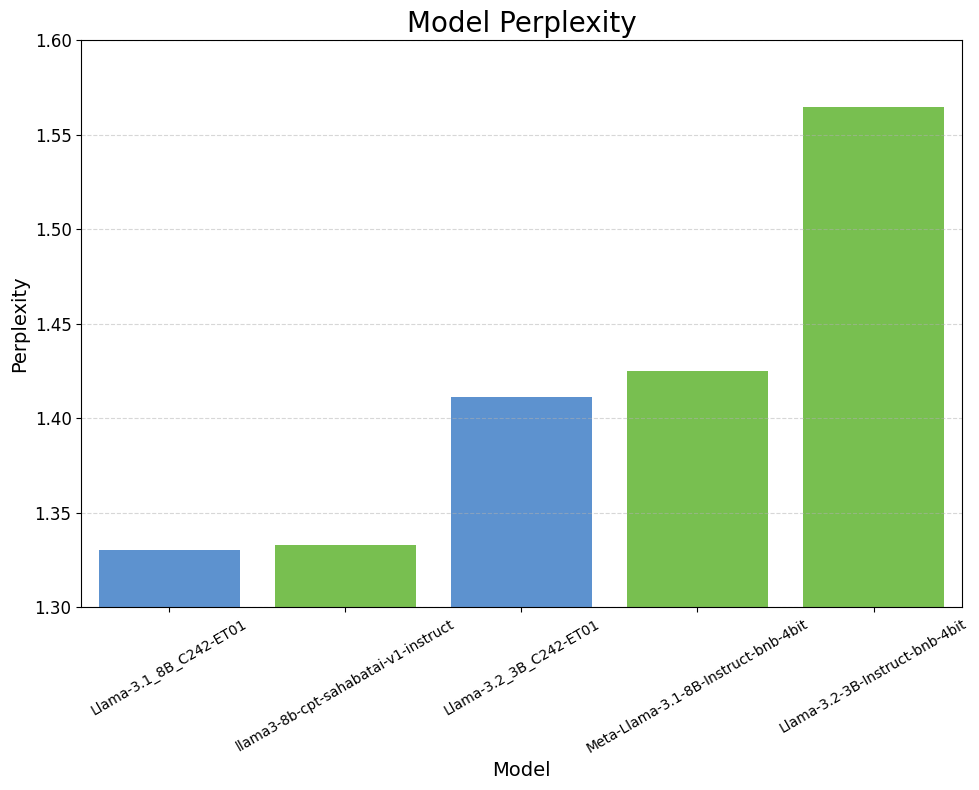

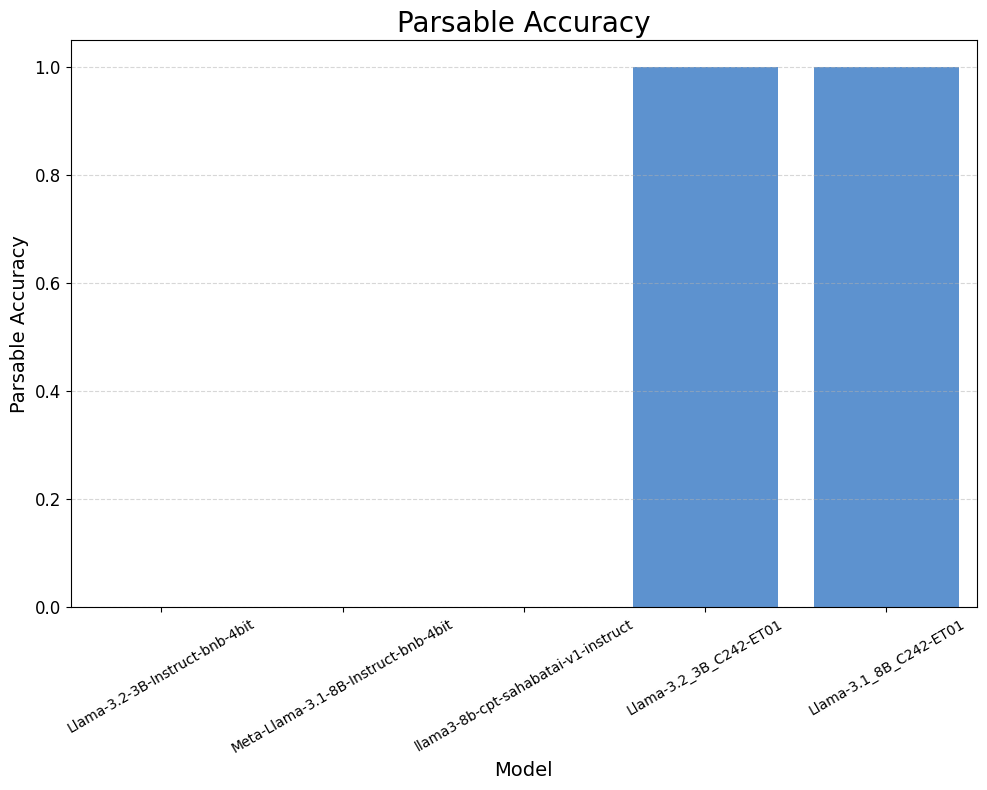

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('result.csv')

# Extract just the model name (without repo owner)
df['model'] = df['model'].str.split('/').str[-1]

sorted_ppl = df.sort_values('perplexity')
sorted_acc = df.sort_values('parsable_acc')

# Create a color map to distinguish C242 models
color_map_ppl = ['#4A90E2' if 'C242' in model else '#73D13D' for model in sorted_ppl['model']]
color_map_acc = ['#4A90E2' if 'C242' in model else '#73D13D' for model in sorted_acc['model']]

# Perplexity plot
plt.figure(figsize=(10, 8))
sns.barplot(x='model', y='perplexity', data=sorted_ppl, palette=color_map_ppl)
plt.title('Model Perplexity', fontsize=20)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Perplexity', fontsize=14)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.ylim(1.3, 1.6)
plt.tight_layout()
plt.savefig('model_perplexity.png', bbox_inches='tight', dpi=300)

# Parsable Accuracy plot
plt.figure(figsize=(10, 8))
sns.barplot(x='model', y='parsable_acc', data=sorted_acc, palette=color_map_acc)
plt.title('Parsable Accuracy', fontsize=20)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Parsable Accuracy', fontsize=14)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('model_parsable_accuracy.png', bbox_inches='tight', dpi=300)

In [ ]:
# import numpy as np
# from tqdm import tqdm

# stats_save_path = "{}.csv".format(model_name.split("/")[-1])
# stats_df = pd.read_csv(stats_save_path)

# with torch.inference_mode():
#   for index, row in tqdm(dataset_test.iterrows(), total=len(dataset_test)):
#       generate_prompt = construct_prompt(row, tokenizer)
#       generated_output = tokenizer.batch_decode(
#           model.generate(**generate_prompt, use_cache=True, top_k=1)[:, generate_prompt['input_ids'].shape[-1]:-1]
#           )

#       parsable, reason = validate_questions_json(generated_output[0])

#       stats_df.loc[index, 'parsable'] = int(parsable)
#       stats_df.loc[index, 'parse_fail_reason'] = reason

# stats_df.to_csv(stats_save_path, index=False)

# parsable_acc = stats_df['parsable'].mean()

# result_df.loc[model_index, 'parsable_acc'] = parsable_acc
# result_df.to_csv(result_path, index=False)